In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from functools import reduce
import scipy.stats as sts
import pprint as pprint # pretty print, something useful
import pickle
%matplotlib inline

**2.5 Exercises**

In [23]:
#WILL5000INDFC
headers = ['date', 'will5000']
will5000 = pd.read_csv('data/WILL5000INDFC.csv', header=None, names=headers, skiprows=1)
will5000['date'] = pd.to_datetime(will5000['date'])
will5000.set_index('date', inplace=True)
will5000['will5000'] = pd.to_numeric(will5000['will5000'], errors='coerce')

#Persnal Consumption Expenditures
price = pd.read_csv('data/PCECC96.csv')
price.columns = ['date', 'price']
price.set_index('date', inplace=True)
price['pce'] = pd.to_numeric(price['price'], errors='coerce')

#GDP Deflator
GDPdefl = pd.read_csv('data/GDPDEF.csv')
GDPdefl.columns = ['date', 'GDP_deflater']
GDPdefl.set_index('date', inplace=True)
GDPdefl['GDP_deflater'] = pd.to_numeric(GDPdefl['GDP_deflater'], errors='coerce')

#3-Month T-Bill Rate
headers = ['date', 'TB3MS']
tb3ms = pd.read_csv('data/TB3MS.csv', header=None, names=headers, skiprows=1)
tb3ms['date'] = pd.to_datetime(tb3ms['date'])
tb3ms.set_index('date', inplace=True)
tb3ms['TB3MS'] = pd.to_numeric(tb3ms['TB3MS'], errors='coerce')

In [24]:
will5000.head() #Checking data

,will5000
date,
1971-01-29,1.05
1971-02-01,NaN
1971-02-02,NaN
1971-02-03,NaN
1971-02-04,NaN


In [25]:
price.head() #Checking data

,price,pce
date,,
1947-01-01,1199.413,1199.413
1947-04-01,1219.329,1219.329
1947-07-01,1223.266,1223.266
1947-10-01,1223.649,1223.649
1948-01-01,1229.757,1229.757


In [26]:
GDPdefl.head() #Checking data

,GDP_deflater
date,
1947-01-01,12.566
1947-04-01,12.745
1947-07-01,12.957
1947-10-01,13.276
1948-01-01,13.379


In [27]:
tb3ms.head() #Checking data

,TB3MS
date,
1934-01-01,0.72
1934-02-01,0.62
1934-03-01,0.24
1934-04-01,0.15
1934-05-01,0.16


In [28]:
will5000 = will5000.resample("D").asfreq()
will5000 = will5000.fillna(method='ffill')
will5000 = will5000.resample("Q").asfreq() # Resampling to quarterly

tb3ms = tb3ms.resample("D").asfreq()
tb3ms = tb3ms.fillna(method='ffill')
tb3ms = tb3ms.resample("Q").asfreq()

will5000.index = will5000.index + pd.DateOffset(1)
tb3ms.index = tb3ms.index + pd.DateOffset(1)

dfs = [will5000, price, GDPdefl, tb3ms]
df = reduce(lambda df1, df2: df1.merge(df2, "outer", left_index=True, right_index=True), dfs)
df = df.dropna(axis=0)
df['will5000_r'] = df['will5000'] / (df['GDP_deflater'] / 100)
df['will5000_return'] = df['will5000_r'] / df['will5000_r'].shift(1)
df['TB3MS'] = (df['TB3MS'] / 100) + 1
df.dropna(axis=0, inplace=True)

In [29]:
df.head() # Check: single dataset with everything in it

,will5000,price,pce,GDP_deflater,TB3MS,will5000_r,will5000_return
date,,,,,,,
1971-07-01,1.13,3020.036,3020.036,24.088,1.0475,4.691133,0.998792
1971-10-01,1.12,3070.230,3070.230,24.288,1.0469,4.611331,0.982989
1972-01-01,1.18,3110.801,3110.801,24.664,1.0401,4.784301,1.037510
1972-04-01,1.26,3170.159,3170.159,24.815,1.0373,5.077574,1.061299
1972-07-01,1.27,3219.095,3219.095,25.048,1.0391,5.070265,0.998561


**Question 1**

In [30]:
class GMMEstimator_q1(object):
    '''GMM Estimator for question 1
    '''
    
    def __init__(self, df, β):
        
        self.df = df
        self.β = β
        
    def calculate_m(self, γ):
        self.df['m'] = self.β * \
        (self.df['price'].shift(-1)/self.df['price']) ** (-γ)
    
    def objective(self, γ):
        μ = self.df.price ** (-γ)
        m = self.β * μ / μ.shift(1)
        R = self.df.will5000_return
        m  = m[1:]
        R = R[1:]
        cov = np.cov(m, R)[0, 1]
        obj = (1 - cov - m.mean() * R.mean())
        
        return obj
        
    def estimate(self, guess):
        γ = opt.broyden1(self.objective, guess)
        return γ

In [31]:
q1 = GMMEstimator_q1(df, .99)
print(q1.estimate(1))

1.3662873078332216


**Question 2**

To determine if this parameter is reasonable, we could see how well the line fits the data and see how linear the curve is. Another thing we could do is compare our results to the literature that is already out there and see if our estimation seems plausible given our calibration.

**Question 3**

In [32]:
class GMMEstimator_q3(object):
    '''GMM Estimator for question 3
    '''
    
    def __init__(self, df, β):
        
        self.df = df
        self.β = β
    
    def objective(self, γ):
        μ = self.df.price ** (-γ)
        m = self.β * μ / μ.shift(1)
        m  = m[1:]
        r_p1 = self.df.TB3MS[1:]
        error = r_p1 - (1 / np.mean(m)) 
        obj = np.sum(error ** 2)

        return obj
        
    def estimate(self, guess):
        γ = opt.minimize(self.objective, guess, method='L-BFGS-B')
        return γ

In [33]:
q3 = GMMEstimator_q3(df, .99)
print(q3.estimate(1))

      fun: 0.22433767437045926
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.7997383e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([4.92158639])


It appears that this value of $\gamma$ is 4.922, which is higher than our other estimate

**Question 4**

In [34]:
class GMMEstimator_q4(object):
    '''GMM Estimator for question 4
    '''
    
    def __init__(self, df):
        
        self.df = df
    
    def objective(self, vec):
        
        γ, β = vec

        moments = np.empty(2)
        W = np.eye(2)  # Specify a weighting matrix; idenity matrix
        
        μ = self.df.price ** (-γ)
        m = β * μ / μ.shift(1)
        R = self.df.will5000_return
        m  = m[1:]
        R = R[1:]
        
        cov = np.cov(m, R)[0, 1]
        moments[0] = (1 - cov - m.mean() * R.mean())
            
        r_p1 = self.df.TB3MS[1:]
        error = r_p1 - (1 / np.mean(m))
        moments[1] = np.sum(error ** 2)
        
        error = (moments.T @ W) @ moments
        
        return error
        
    def estimate(self, guess):
        params = opt.minimize(self.objective, guess, method='L-BFGS-B', 
                             bounds=((1e-3, None), (1e-3, 1)))
        return params
        

In [35]:
q4 = GMMEstimator_q4(df)

In [36]:
print(q4.estimate([3,1]))

      fun: 0.050994332316042
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.42509959e-06, -6.91807722e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 4
   status: 0
  success: True
        x: array([3.00110347, 0.9765263 ])


It appears that this value of $\gamma$ is 4.922, which is higher than our other estimate

In [37]:
n = 60
N = 5
gr_γ = np.linspace(1, 5, n)
gr_β = np.linspace(0.95, 0.99, N)

est = np.empty((n, N))
for i in range(n):
    for j in range(N):
        est[i, j] = q4.objective([gr_γ[i], gr_β[j]])

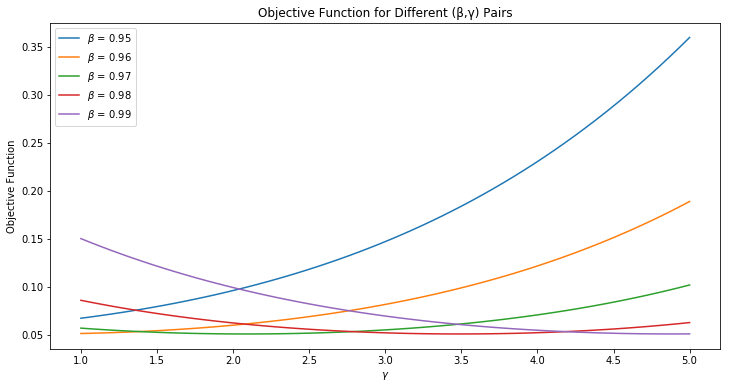

In [38]:
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(gr_γ, est[:, i], label=rf'$\beta$ = {gr_β[i]:.2f}')
plt.title('Objective Function for Different (β,γ) Pairs')
plt.xlabel('$\gamma$')
plt.ylabel('Objective Function')
plt.legend()
plt.show()

This graph is visually stimulating my ocular sensory.

This value of $\gamma$ appears to be somewhere between the previous two parameter estimates.

**3.5 Exercises**

In [2]:
# Import data
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

**Question 1**

In [3]:
class OrderBook:
    '''This class represents a single orderbook, where the data for
    that single orderbook is an instance property.
    '''
    
    def __init__(self, data, l_bnd, u_bnd):
    
        self.data = data[1]
        self.time = data[0]
        self.l_bnd = l_bnd
        self.u_bnd = u_bnd
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)

        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.mid = orders[orders.Q < 0].index.values[0]
        
        self.orders = orders[(orders.index > l_bnd * self.mid) 
                             & (orders.index < u_bnd * self.mid)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.γ = intercept
        self.β = slope
        self.p = - self.γ/self.β
        self.ratio = self.β    

    def plot(self, name):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Quantity Supplied')
        p_grid = np.linspace(self.l_bnd * self.mid, self.u_bnd * self.mid)
        plt.plot(p_grid, self.γ + self.β * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.mid, 1.5 * self.mid)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(name + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def test(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.mid)
        

In [4]:
def display(file_obj, t, name):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot(name)
    test.test()

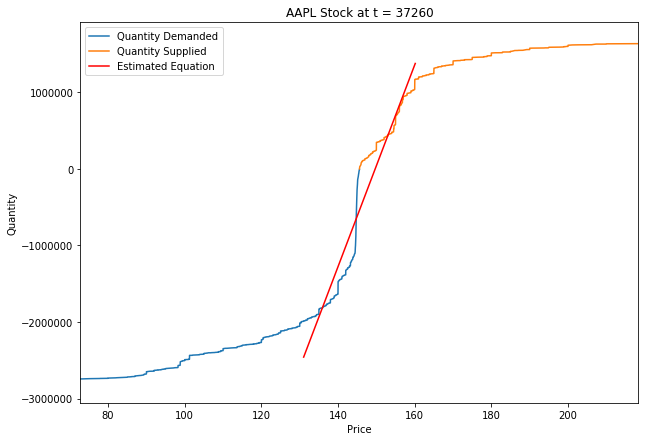

The estimated p_0 is: 149.686787
The actual midpoint of the BBO is: 145.580000


In [5]:
display(file_objs[0], 50, 'AAPL')

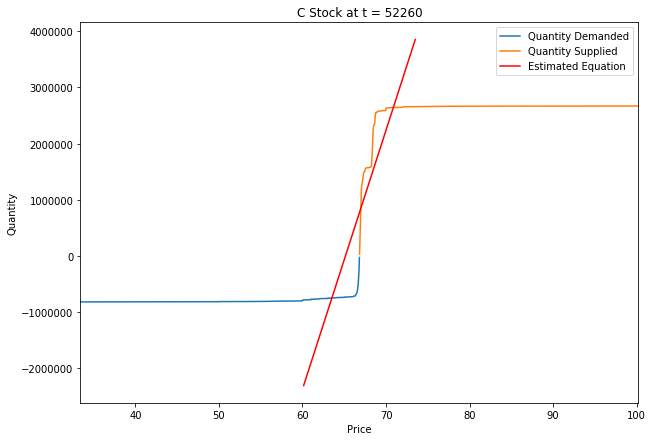

The estimated p_0 is: 65.141571
The actual midpoint of the BBO is: 66.820000


In [6]:
display(file_objs[1], 300, 'C')

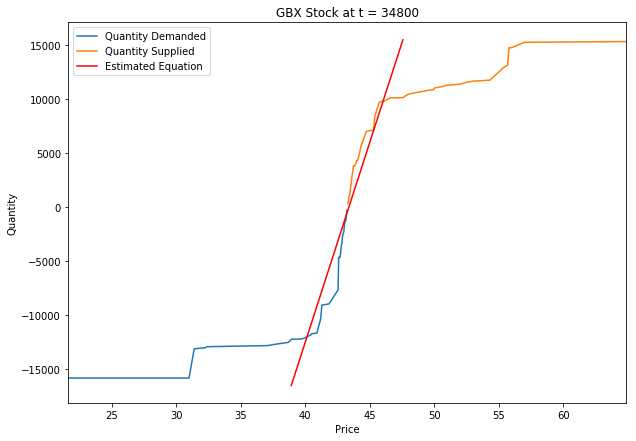

The estimated p_0 is: 43.393255
The actual midpoint of the BBO is: 43.250000


In [7]:
display(file_objs[2], 9, 'GBX')

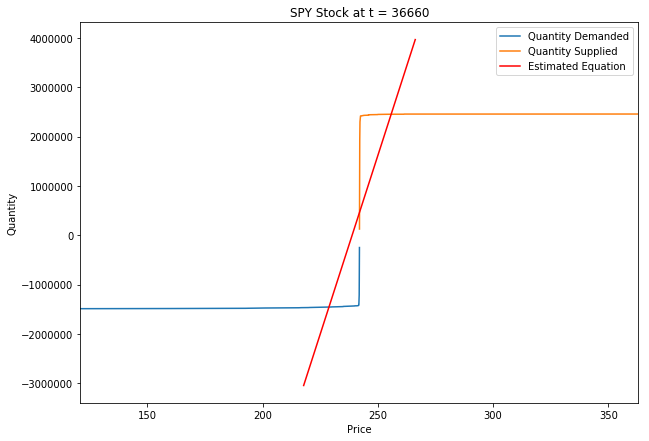

The estimated p_0 is: 238.868532
The actual midpoint of the BBO is: 242.040000


In [8]:
display(file_objs[3], 40, 'SPY')

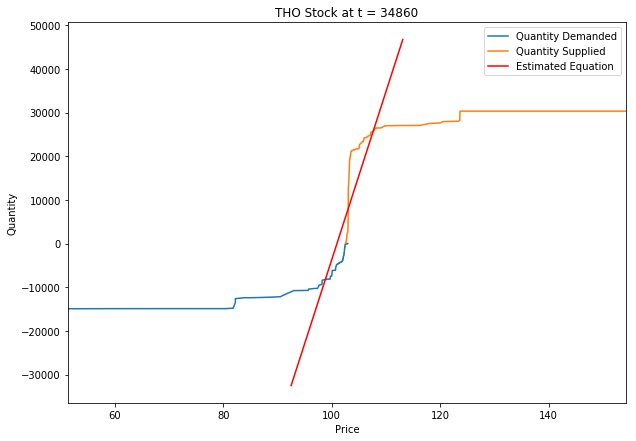

The estimated p_0 is: 100.966398
The actual midpoint of the BBO is: 102.810000


In [9]:
display(file_objs[4], 10, 'THO')

The model fits well where the supply and demand curves meet, but does not fit well on the extrema of the curves (the prices farthest out in both directions). So, it might be best to use a subset of the data, perhaps at some smaller threshold around where the curves meet.

**Question 2**

In [10]:
def plot_ratio(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], .9, 1.1)
        book.estimate()
        ratio[i] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
    plt.show()

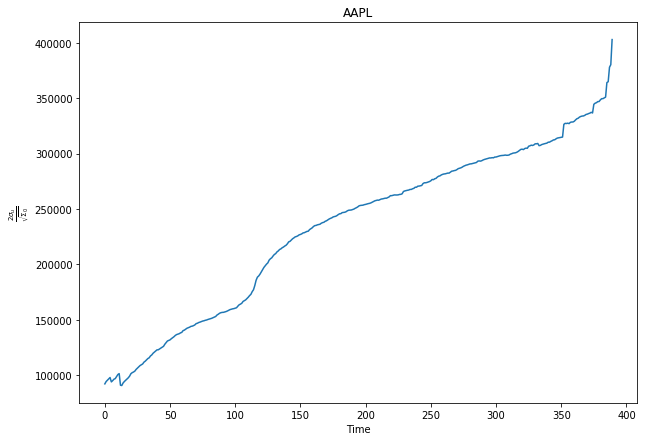

In [11]:
plot_ratio(file_objs[0], 'AAPL')

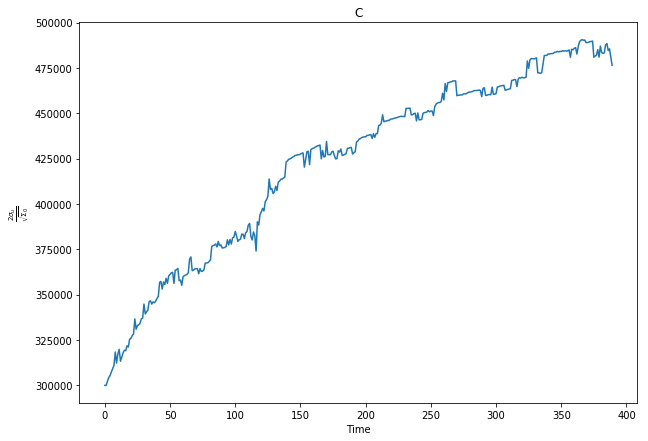

In [12]:
plot_ratio(file_objs[1], 'C')

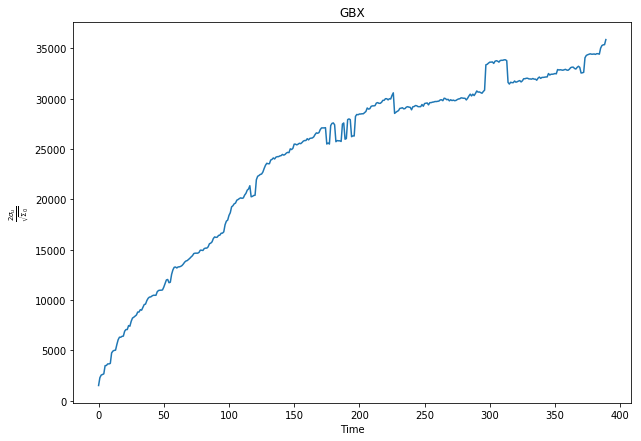

In [13]:
plot_ratio(file_objs[2], 'GBX')

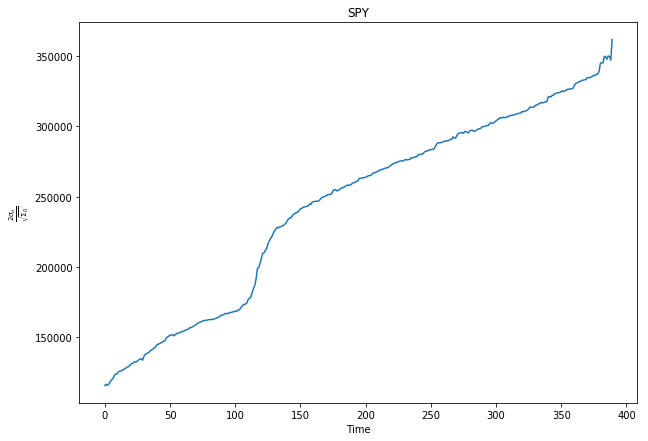

In [14]:
plot_ratio(file_objs[3], 'SPY')

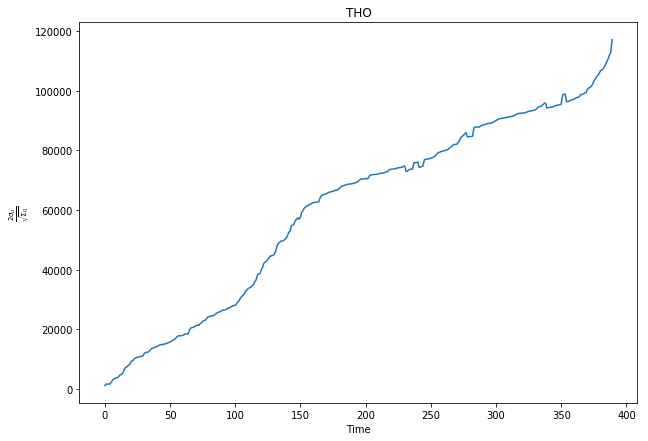

In [15]:
plot_ratio(file_objs[4], 'THO')

**Questions 3 and 4**

In [16]:
def comp_est(file_obj, title, cutval=1):
    p_est = np.zeros(len(file_obj), dtype=np.float64)
    p_act = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], .9, 1.1)
        book.estimate()
        p_est[i] = book.p
        p_act[i] = book.mid
    
    fig = plt.figure(figsize=(8,5))
    plt.plot(p_est - p_act, label=r'$\hat{p}_0 - p_0$')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'Difference')
    plt.show()
    
    fig = plt.figure(figsize=(8,5))
    plt.plot(p_est, label='Estimated p')
    plt.plot(p_act, label='Actual p')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$p$')
    plt.show()

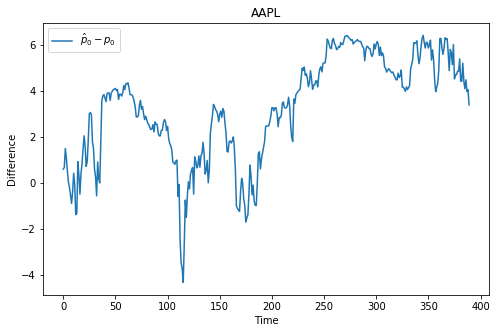

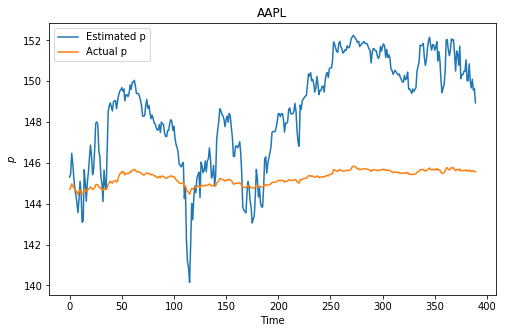

In [17]:
comp_est(file_objs[0], 'AAPL')

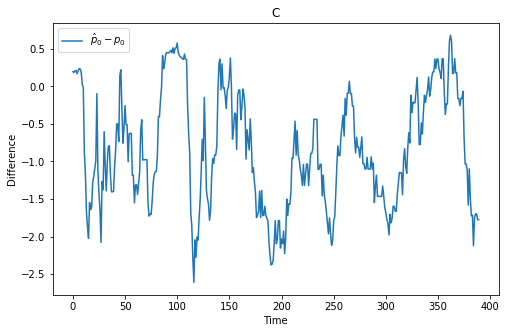

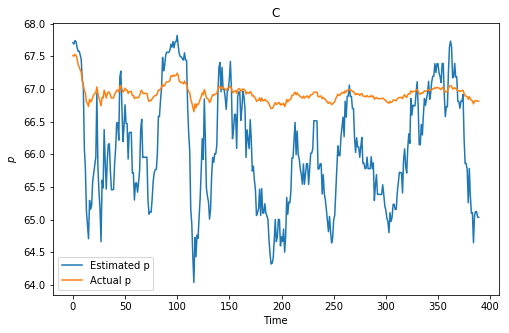

In [18]:
comp_est(file_objs[1], 'C')

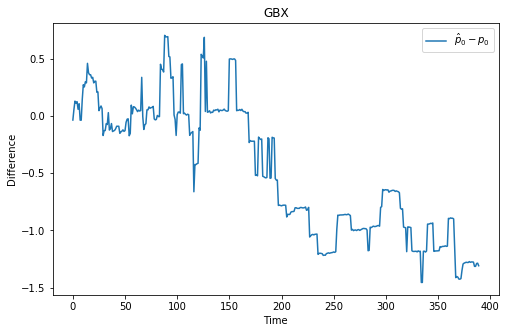

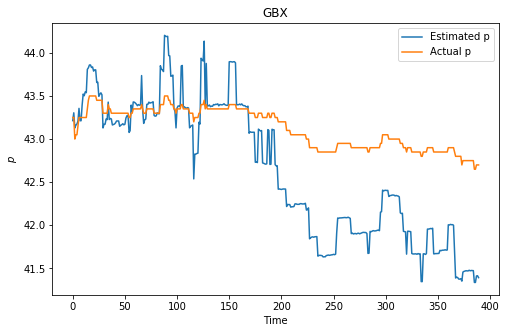

In [19]:
comp_est(file_objs[2], 'GBX')

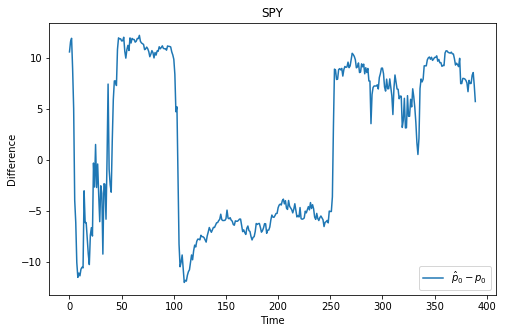

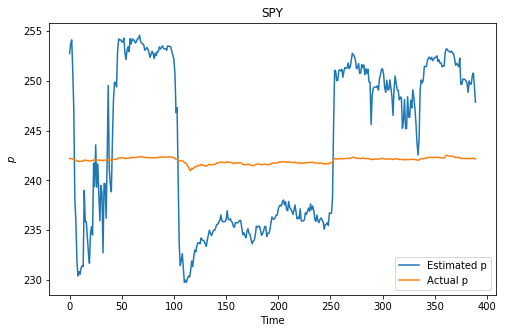

In [20]:
comp_est(file_objs[3], 'SPY')

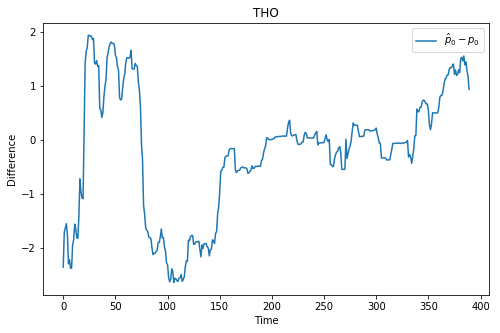

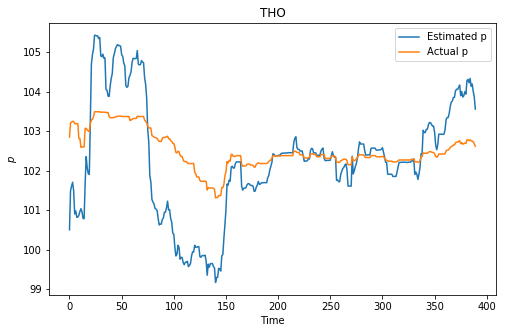

In [21]:
comp_est(file_objs[4], 'THO')

The estimates of $p_0$ seem to be more viable than the actual midpoint of the BBO over time. The nature of the orderbook and the estimation procedure we are using may be more sensitive at certain points over time. Hence, the true midpoint may not be truthfully represented.

I would expect the noise/signal ratios calculated as well as the movements in $p_0$ to have been worse in estimation for those tickers that had more noise associated with them. We can see this from the graphs above.